In [107]:
import sys
import itertools
from pathlib import Path

import numpy as np
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.cluster import KMeans

sys.path.insert(0, "../")
from biotoolbox.dbutils import MemoryMappedDatasetReader

In [101]:
def make_reader(database_path):
    return MemoryMappedDatasetReader(database_path, start=True)

metadata = pd.read_table("../metadata/domain-classifications.tsv")

databases = [[make_reader(p), p] for p in sorted(list(Path("../databases/").iterdir()))]

names   = list(itertools.chain(*databases[0][0].ids()))
cath_md = metadata[metadata.DOMAIN.isin(names)]

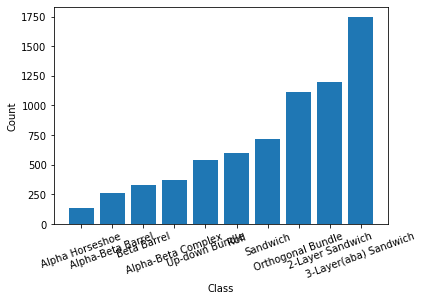

In [202]:
class_counts = Counter(cath_md.ARCH.values)
# get classes with at least 5 representatives
classes, counts = zip(*list(filter(lambda x: x[1] >= 100, sorted(class_counts.items(), key=lambda x: x[1]))))
cath_md_gt5 = cath_md[cath_md.ARCH.isin(classes)]
plt.bar(range(len(classes)), counts)
plt.xticks(range(len(classes)), classes, rotation=20)
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [203]:
kmeans = []
Nc = len(classes)

from datetime import datetime
start = datetime.now()

for db, path in databases:
    model = path.stem
    substart = datetime.now()
    X = np.array([db.get(x) for x in cath_md_gt5.DOMAIN.values])
    if not Path(f"./kmean_files/{model}.kmeans").exists():
        #print(f"{model}: {substart}, ({substart - start} already done)")
        #print(X)
        km = KMeans(n_clusters=Nc).fit(X)
        joblib.dump(km, f"./kmean_files/{model}.kmeans")
    else:
        km = joblib.load(f"./kmean_files/{model}.kmeans")
    kmeans.append([model, km])
    
    print(f"{model}: ({datetime.now() - substart}, {datetime.now() - start} total elapsed)")

gae_128x2__96x1__64x2: (0:00:20.828488, 0:00:20.830002 total elapsed)
gae_128x4: (0:00:19.665528, 0:00:40.495742 total elapsed)
gae_64x5: (0:00:12.168844, 0:00:52.666239 total elapsed)
gae_64x7: (0:00:17.942057, 0:01:10.608769 total elapsed)
gae_96x4: (0:00:13.848053, 0:01:24.457209 total elapsed)


In [205]:
counter  = 0
topo2num = dict()
y   = []
for topo in cath_md_gt5.ARCH.values:
    try:
        lnum = topo2num[topo]
    except KeyError:
        lnum = topo2num[topo] = counter
        counter += 1
    y.append(lnum)
    
y = np.array(y)

In [206]:
from sklearn.metrics import normalized_mutual_info_score as nmi, adjusted_mutual_info_score as ami

In [207]:
print(f"{'model':<23s} {'NMI':>5s} {'AMI':>6s}")
print("-------------------------------------")
for mod, km in kmeans:
    yhat = km.labels_
    print(f"{mod:<23s} {nmi(y, yhat):0.4f} {ami(y, yhat):0.4f}")

model                     NMI    AMI
-------------------------------------
gae_128x2__96x1__64x2   0.1011 0.0985
gae_128x4               0.0994 0.0968
gae_64x5                0.0972 0.0946
gae_64x7                0.0985 0.0959
gae_96x4                0.1039 0.1012
